In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5597, 5)

## Data cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597 entries, 0 to 5596
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5597 non-null   object
 1   v2          5597 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 218.8+ KB


In [6]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5597,5597,50,12,6
unique,2,5194,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [7]:
df.drop(columns=['Unnamed: 2',	'Unnamed: 3',	'Unnamed: 4'],inplace=True)
df.rename(columns={'v1':'category','v2':'message'},inplace=True)
df

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5592,spam,Hi User Pounce on Puma perfection! Grab footwe...
5593,spam,Dear Customer SMART Bazaar invites you to the ...
5594,spam,Dear Customer Rs.2601 CREDITED in Lenskart A/c...
5595,spam,Godrej-Big-Bull-Kandivali-E Opp.Growel-101-Mal...


In [8]:
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
df.head()

,category,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.isnull().sum()

category    0
message     0
dtype: int64

In [10]:
df.duplicated().sum()

403

In [11]:
df = df.drop_duplicates(keep='first')

## EDA

In [12]:
df['category'].value_counts()

category
0    4516
1     678
Name: count, dtype: int64

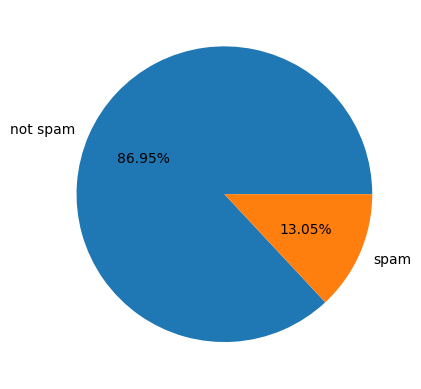

In [13]:
fig, axis = plt.subplots()
axis.pie(df['category'].value_counts(),labels=['not spam','spam'],autopct='%0.2f%%')
plt.show()


In [14]:
df.loc[:,['number_char']] = df['message'].apply(len)

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
df.loc[:,['number_words']] = df['message'].apply(lambda x:len(nltk.word_tokenize(x)))

In [17]:
df.loc[:,['number_sentences']] = df['message'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [18]:
df.head()

,category,message,number_char,number_words,number_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [19]:
df[['number_char','number_words','number_sentences']].describe()

,number_char,number_words,number_sentences
count,5194.000000,5194.000000,5194.000000
mean,79.490181,18.478629,1.965345
std,58.381657,13.313895,1.446508
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,118.750000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [20]:
#Not spam
df[df['category'] == 0][['number_char','number_words','number_sentences']].describe()

,number_char,number_words,number_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.684234,17.123782,1.820195
std,56.435582,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [21]:
#spam
df[df['category'] == 1][['number_char','number_words','number_sentences']].describe()

,number_char,number_words,number_sentences
count,678.000000,678.000000,678.000000
mean,138.144543,27.502950,2.932153
std,30.674684,7.177996,1.484971
min,13.000000,2.000000,1.000000
25%,130.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,158.000000,32.000000,4.000000
max,270.000000,54.000000,9.000000


<Axes: xlabel='number_char', ylabel='Count'>

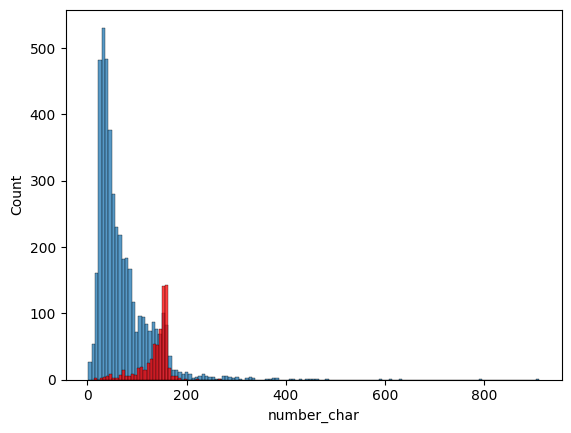

In [22]:
sns.histplot(df[df['category'] == 0]['number_char'])
sns.histplot(df[df['category'] == 1]['number_char'],color='red')

<Axes: xlabel='number_words', ylabel='Count'>

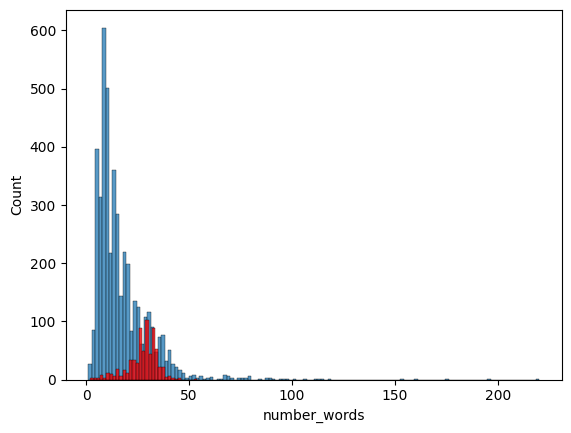

In [23]:
sns.histplot(df[df['category'] == 0]['number_words'])
sns.histplot(df[df['category'] == 1]['number_words'],color='red')

<Axes: xlabel='number_sentences', ylabel='Count'>

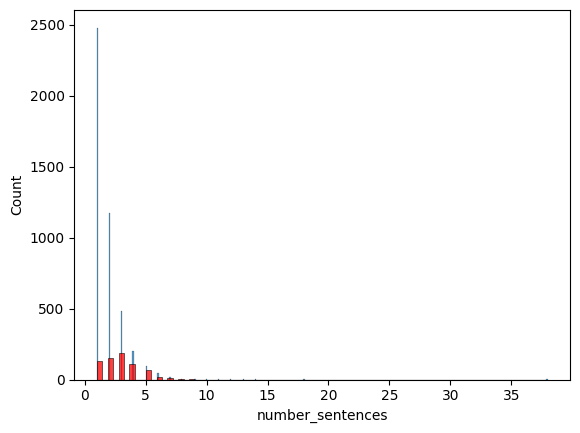

In [24]:
sns.histplot(df[df['category'] == 0]['number_sentences'])
sns.histplot(df[df['category'] == 1]['number_sentences'],color='red')

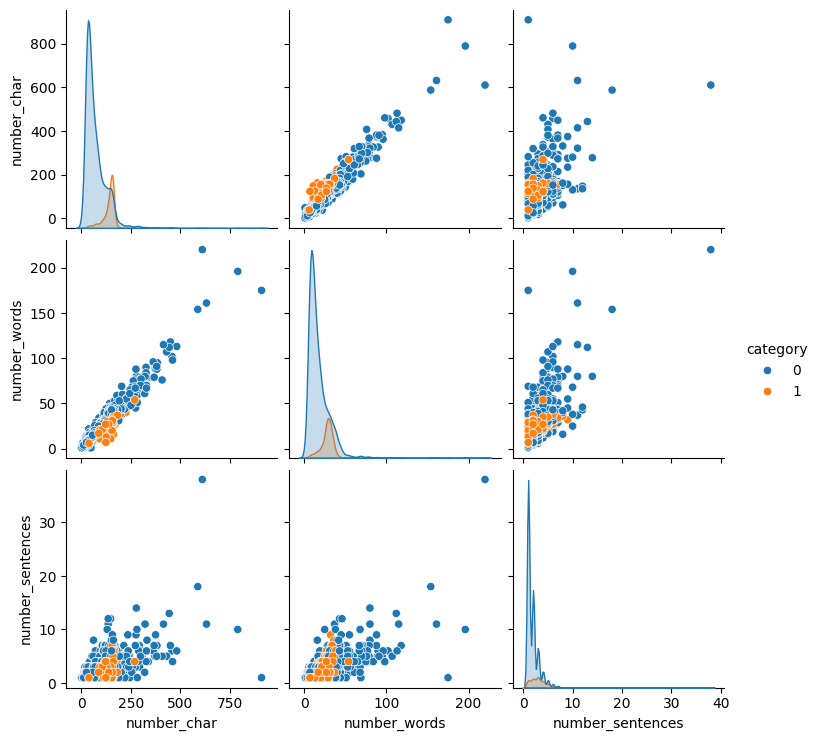

In [25]:
sns.pairplot(df,hue='category')

In [26]:
df[['category','number_char','number_words','number_sentences']].corr()

,category,number_char,number_words,number_sentences
category,1.000000,0.389317,0.262657,0.259000
number_char,0.389317,1.000000,0.964196,0.621440
number_words,0.262657,0.964196,1.000000,0.679552
number_sentences,0.259000,0.621440,0.679552,1.000000


## Data pre processing

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
def preprocessing(msg):
    msg = msg.lower()
    msg = nltk.word_tokenize(msg)

    y=[]
    for i in msg:
        if i.isalnum():
            if i not in stopwords.words('english') and i not in string.punctuation:
                ps = PorterStemmer()
                y.append(ps.stem(i))
    return " ".join(y)

In [29]:
df.loc[:,['processed_msg']] = df['message'].apply(preprocessing)

In [30]:
df.head()

,category,message,number_char,number_words,number_sentences,processed_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [31]:
spam_words = [ ]
for msg in df[df['category'] == 1]['processed_msg'].tolist():
    for word in msg.split():
        spam_words.append(word)
spam_common_words = pd.DataFrame(Counter(spam_words).most_common(30))

<BarContainer object of 30 artists>

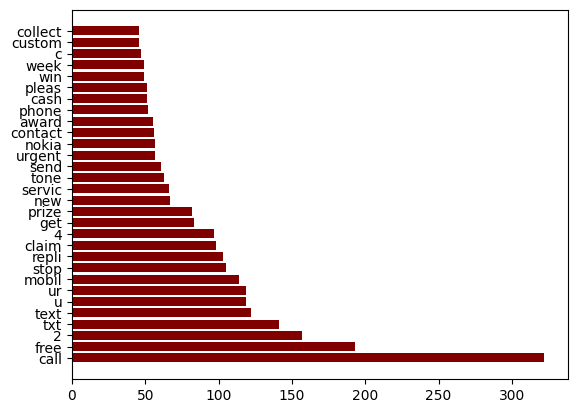

In [32]:
plt.barh(spam_common_words[0],spam_common_words[1],color='maroon')

In [33]:
not_spam_words = [ ]
for msg in df[df['category'] == 0]['processed_msg'].tolist():
    for word in msg.split():
        not_spam_words.append(word)
spam_common_words = pd.DataFrame(Counter(not_spam_words).most_common(30))

<BarContainer object of 30 artists>

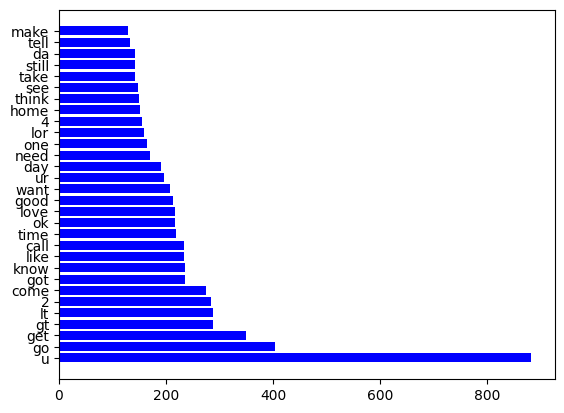

In [34]:
plt.barh(spam_common_words[0],spam_common_words[1],color='blue')

## Model Building

In [35]:
#Balancing Dataset
count_class_0, count_class_1 = df.category.value_counts()
count_class_0, count_class_1

(4516, 678)

In [36]:
df_class_0 = df[df['category'] == 0]
df_class_1 = df[df['category'] == 1]

<Axes: title={'center': 'Count (target)'}, xlabel='category'>

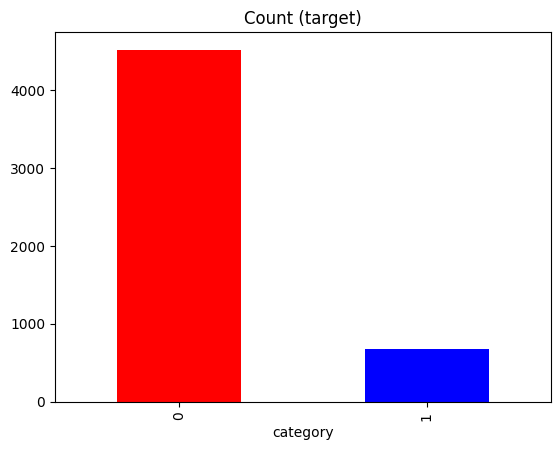

In [37]:
df.category.value_counts().plot(kind='bar', title='Count (target)', color=['red','blue'])

In [38]:
df_class_1_new = df_class_1.sample(count_class_0,replace=True)
balanced_df  = pd.concat([df_class_0,df_class_1_new],axis=0)

<Axes: title={'center': 'Count (target)'}, xlabel='category'>

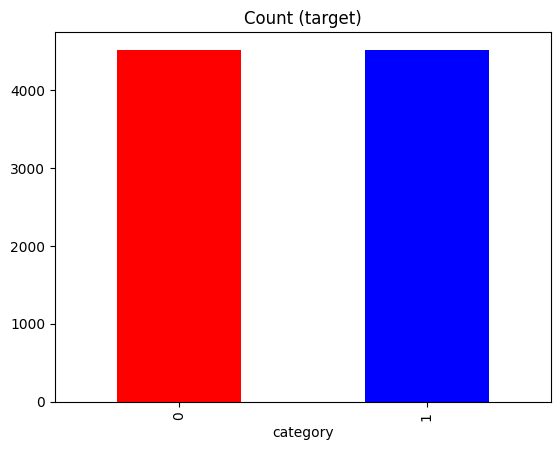

In [39]:
balanced_df.category.value_counts().plot(kind='bar', title='Count (target)', color=['red','blue'])

In [40]:
vectorizer = CountVectorizer()
tfidf_vectorizer =TfidfVectorizer(max_features=3000)
X = tfidf_vectorizer.fit_transform(balanced_df['processed_msg']).toarray()
X.shape


(9032, 3000)

In [41]:
Y = balanced_df['category'].values
Y

array([0, 0, 0, ..., 1, 1, 1])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [43]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_prediction = gnb.predict(X_test)

print(accuracy_score(y_test,y_prediction))
print(confusion_matrix(y_test,y_prediction))
print(precision_score(y_test,y_prediction))


0.9828444936358606
[[899  18]
 [ 13 877]]
0.9798882681564246


In [44]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [45]:
classifiers = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt
}

In [46]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [47]:
accuracy_scores = []
precision_scores = []

for name,clf in classifiers.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9872717210846708
Precision -  0.9865319865319865
For  KN
Accuracy -  0.96956281128943
Precision -  0.9976162097735399
For  NB
Accuracy -  0.9679026009961261
Precision -  0.9642857142857143
For  DT
Accuracy -  0.8599889319313779
Precision -  0.9263721552878179
For  LR
Accuracy -  0.9822910902047592
Precision -  0.9841986455981941
For  RF
Accuracy -  0.9988931931377975
Precision -  0.9977578475336323


c:\Users\Admin\anaconda3\envs\py310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


For  AdaBoost
Accuracy -  0.9474266740453791
Precision -  0.9616724738675958
For  BgC
Accuracy -  0.977863862755949
Precision -  0.956989247311828
For  ETC
Accuracy -  0.9988931931377975
Precision -  0.9977578475336323
For  GBDT
Accuracy -  0.9153292750415053
Precision -  0.9466666666666667


In [48]:
performance_df = pd.DataFrame({'Algorithm':classifiers.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
5,RF,0.998893,0.997758
8,ETC,0.998893,0.997758
1,KN,0.969563,0.997616
0,SVC,0.987272,0.986532
4,LR,0.982291,0.984199
2,NB,0.967903,0.964286
6,AdaBoost,0.947427,0.961672
7,BgC,0.977864,0.956989
9,GBDT,0.915329,0.946667
3,DT,0.859989,0.926372


In [49]:
rfc.fit(X_train,y_train)
y_prediction = knc.predict(X_test)

print(accuracy_score(y_test,y_prediction))
print(confusion_matrix(y_test,y_prediction))
print(precision_score(y_test,y_prediction))

0.96956281128943
[[915   2]
 [ 53 837]]
0.9976162097735399


In [51]:
pickle.dump(tfidf_vectorizer,open('vectorize.pkl', 'wb'))
pickle.dump(rfc,open('model.pkl', 'wb'))